Data: 60 samples, dt=1.017s, total_duration=60.0s
MAX_ALLOWED_LAG_SEC=10 → MIN_OVERLAP_SEC=50.0 s
Allowed lag window (samples): |lag| <= 11 samples (≈ 11.19 s)
Best lag: 5 samples = 5.08 s
Second-best lag: nan samples = N/A s
Pearson correlation (aligned): 0.638 (p=1.635825997326599e-07)
Spearman correlation (aligned): 0.592 (p=1.9219631678169297e-06)


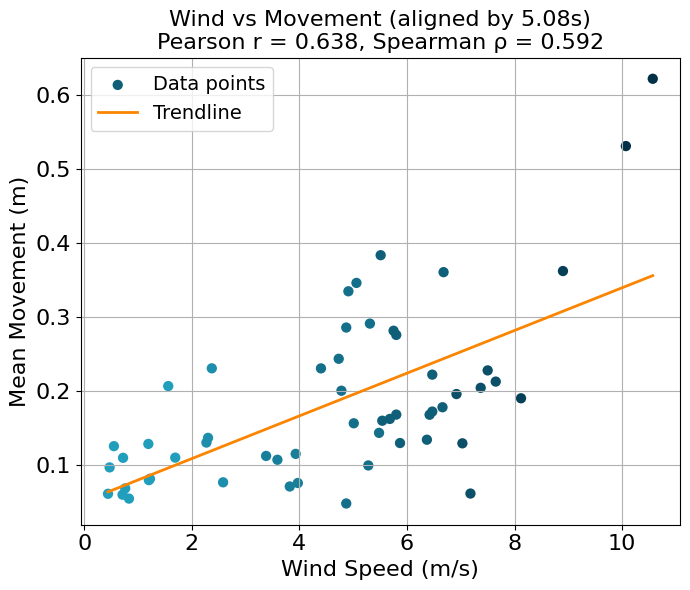

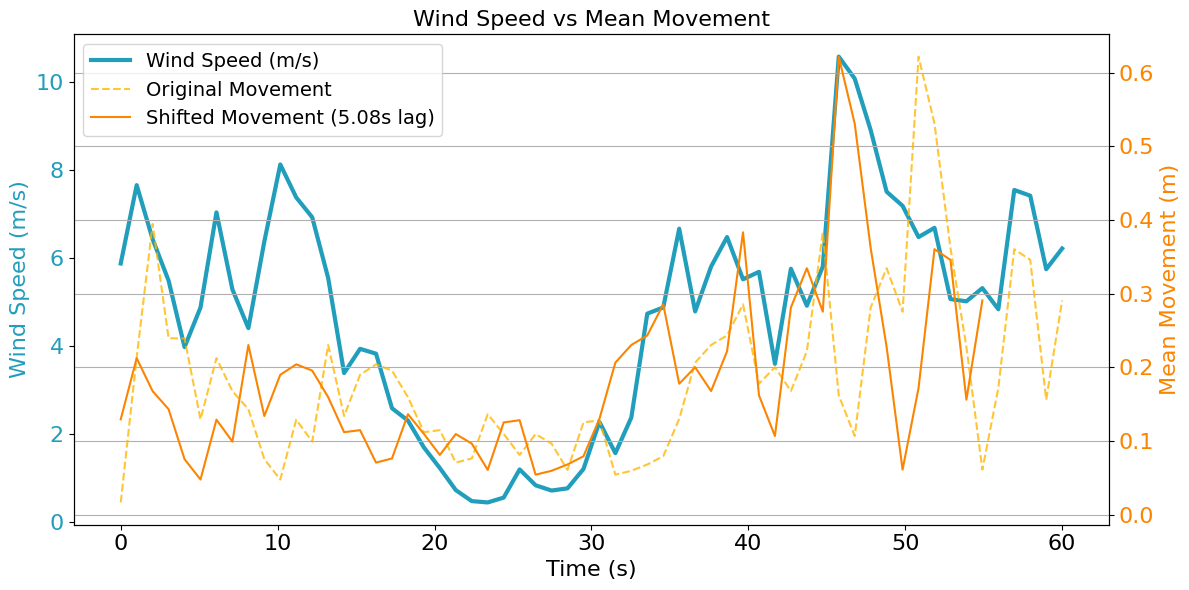

In [ ]:
import re, math, numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.stats import pearsonr, spearmanr
from matplotlib.colors import to_rgb


WIND_PATH = 'wind_data.csv' #File that has the measured Wind data (speed and direction)
MOVEMENT_TXT = 'scan2comp_summary.txt' #Overview file that shows the mean, max and median movemen and the average movement direction of each frame
SCAN_LENGTH = 60 #Scan length in seconds (this works for 1Hz sampled data)
MAX_ALLOWED_LAG_SEC = 10 #Set a realistic maximum lag, depending on the windspeed and the distance to the tree

def shift_no_wrap(arr, shift):
    """Shift 1D array without circular wrap. Positive shift moves right (delay).
    Vacated entries filled with np.nan."""
    a = np.asarray(arr)
    n = len(a)
    result = np.full(n, np.nan, dtype=a.dtype)
    if shift == 0:
        result[:] = a
    elif shift > 0:
        if shift < n:
            result[shift:] = a[:-shift]
    else:  # shift < 0
        s = -shift
        if s < n:
            result[:-s] = a[s:]
    return result

def effective_overlap_length(n, lag):
    """Number of overlapping samples between two equal-length signals when shifted by lag."""
    return n - abs(lag)

def normalized_cross_correlation(x, y):
    """Return (ncc, lags) where lags range from -(n-1) .. (n-1).
    Normalization is computed per-lag using overlapping (non-NaN) samples."""
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    n = len(x)
    xm = x - np.nanmean(x)
    ym = y - np.nanmean(y)
    xm_f = np.nan_to_num(xm, nan=0.0)
    ym_f = np.nan_to_num(ym, nan=0.0)
    raw = correlate(xm_f, ym_f, mode='full')
    lags = np.arange(-n+1, n)
    norm = np.empty_like(raw, dtype=float)
    for idx, lag in enumerate(lags):
        if lag < 0:
            xa = xm[-lag:]
            ya = ym[:n+lag]
        else:
            xa = xm[:n-lag]
            ya = ym[lag:]
        valid = (~np.isnan(xa)) & (~np.isnan(ya))
        if valid.sum() == 0:
            norm[idx] = np.nan
        else:
            xs = (xa[valid]**2).sum()
            ys = (ya[valid]**2).sum()
            denom = math.sqrt(xs * ys)
            norm[idx] = denom if denom > 0 else np.nan
    ncc = raw / norm
    return ncc, lags

# Load data
wind_df = pd.read_csv(WIND_PATH, header=None, usecols=[0,2,3], names=['time','wdirection','speed']).dropna().reset_index(drop=True)
wind_df['time_sec'] = np.linspace(0, SCAN_LENGTH, len(wind_df))

pattern = re.compile(r".+\.txt: max=([\d\.eE+-]+), mean=([\d\.eE+-]+), median=([\d\.eE+-]+), avg_direction=\[([^\]]+)\]")
frames = []
frame_counter = 0
with open(MOVEMENT_TXT, 'r') as f:
    for line in f:
        m = pattern.search(line)
        if m:
            max_val = float(m.group(1))
            mean_val = float(m.group(2))
            median_val = float(m.group(3))
            direction = [float(x.strip()) for x in m.group(4).split(',') if x.strip()!='']
            frames.append((frame_counter, max_val, mean_val, median_val, direction))
            frame_counter += 1

movement_df = pd.DataFrame(frames, columns=['frame','max','mean','median','direction']).sort_values('frame').reset_index(drop=True)
movement_df['time_sec'] = np.linspace(0, SCAN_LENGTH, len(movement_df))

# Interpolate movement to wind timestamps
movement_interp = np.interp(wind_df['time_sec'], movement_df['time_sec'], movement_df['mean'])
combined = pd.DataFrame({'time_sec': wind_df['time_sec'], 'wind_speed': wind_df['speed'].values, 'movement': movement_interp})

n = len(combined)
dt = combined['time_sec'].iloc[1] - combined['time_sec'].iloc[0]
total_duration_sec = combined['time_sec'].iloc[-1] - combined['time_sec'].iloc[0]

MIN_OVERLAP_SEC = max(0.0, total_duration_sec - MAX_ALLOWED_LAG_SEC)
min_overlap_samples = int(round(MIN_OVERLAP_SEC / dt))
max_allowed_lag_samples = n - min_overlap_samples

print(f"Data: {n} samples, dt={dt:.3f}s, total_duration={total_duration_sec:.1f}s")
print(f"MAX_ALLOWED_LAG_SEC={MAX_ALLOWED_LAG_SEC} → MIN_OVERLAP_SEC={MIN_OVERLAP_SEC} s")
print(f"Allowed lag window (samples): |lag| <= {max_allowed_lag_samples} samples (≈ {max_allowed_lag_samples*dt:.2f} s)")

#Cross-correlation / lag detection with constraints
wind = combined['wind_speed'].values
move = combined['movement'].values

#Compute normalized cross-correlation
ncc, lags = normalized_cross_correlation(move, wind)

valid_overlap_mask = np.array([effective_overlap_length(n, lag) >= min_overlap_samples for lag in lags])
valid_mask_time = np.abs(lags * dt) <= MAX_ALLOWED_LAG_SEC + 1e-8
valid_mask = valid_overlap_mask & valid_mask_time

ncc_masked = ncc.copy()
ncc_masked[~valid_mask] = np.nan

if np.all(np.isnan(ncc_masked)):
    raise RuntimeError("No valid lags remain under current MIN_OVERLAP_SEC / MAX_ALLOWED_LAG_SEC. Relax constraints.")

best_idx = np.nanargmax(ncc_masked)
best_lag = lags[best_idx]
best_lag_sec = best_lag * dt

#find second best lag (just to check)
neighborhood = min_overlap_samples
ncc_masked2 = ncc_masked.copy()
start = max(0, best_idx - neighborhood); end = min(len(ncc_masked2), best_idx + neighborhood + 1)
ncc_masked2[start:end] = np.nan
if np.all(np.isnan(ncc_masked2)):
    second_lag = np.nan; second_lag_sec = np.nan
else:
    second_idx = np.nanargmax(ncc_masked2)
    second_lag = lags[second_idx]; second_lag_sec = second_lag * dt

print(f"Best lag: {best_lag} samples = {best_lag_sec:.2f} s")
print(f"Second-best lag: {second_lag} samples = {second_lag_sec if not np.isnan(second_lag_sec) else 'N/A'} s")

#Align using no-wrap shift (pad with NaN) and compute correlations
lag_samples = int(best_lag)
movement_shifted = shift_no_wrap(combined['movement'].values, -lag_samples)
combined['movement_shifted'] = movement_shifted

# Compute Pearson and Spearman using only valid overlapping samples
valid_corr_mask = ~np.isnan(combined['movement_shifted'].values)
if valid_corr_mask.sum() >= 3:
    pearson_r, pearson_p = pearsonr(combined['wind_speed'].values[valid_corr_mask], combined['movement_shifted'].values[valid_corr_mask])
else:
    pearson_r, pearson_p = np.nan, np.nan

spearman_rho, spearman_p = spearmanr(combined['wind_speed'].values[valid_corr_mask], combined['movement_shifted'].values[valid_corr_mask]) if valid_corr_mask.sum() >= 3 else (np.nan, np.nan)

print(f"Pearson correlation (aligned): {pearson_r:.3f} (p={pearson_p})")
print(f"Spearman correlation (aligned): {spearman_rho:.3f} (p={spearman_p})")

#Plot 1 Correlation Plot
fig, ax = plt.subplots(figsize=(7, 6))

start_color = np.array(to_rgb("#219EBC"))
end_color   = np.array(to_rgb("#023047"))

winds = combined["wind_speed"].values
num_steps = 8
bins = np.linspace(winds.min(), winds.max(), num_steps+1)
digitized = np.digitize(winds, bins) - 1
digitized = np.clip(digitized, 0, num_steps-1)

gradient_colors = [ start_color + (end_color - start_color) * (i / (num_steps - 1)) for i in range(num_steps)]

point_colors = np.array([gradient_colors[i] for i in digitized])

sc = ax.scatter(combined["wind_speed"], combined["movement_shifted"], c=point_colors, edgecolor="none", s=55,label="Data points")

#Fit regression using valid overlapping samples only
x_valid = combined["wind_speed"].values[valid_corr_mask]
y_valid = combined["movement_shifted"].values[valid_corr_mask]
if len(x_valid) >= 2:
    coeffs = np.polyfit(x_valid, y_valid, 1)
    trend = np.poly1d(coeffs)
    x_vals = np.linspace(x_valid.min(), x_valid.max(), 100)
ax.plot(x_vals, trend(x_vals), color="#fb8500", linewidth=2, label="Trendline")

ax.set_xlabel("Wind Speed (m/s)", fontsize=16)
ax.set_ylabel("Mean Movement (m)", fontsize=16)
ax.set_title(f"Wind vs Movement (aligned by {best_lag_sec:.2f}s)\n" f"Pearson r = {pearson_r:.3f}, Spearman ρ = {spearman_rho:.3f}", fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=14)
ax.grid(True)
plt.tight_layout()
plt.show()


# Plot 2 Dual-axis overlay of wind and movement
fig, ax1 = plt.subplots(figsize=(12,6))

#Left y-axis: Wind speed
ax1.plot(combined["time_sec"], combined["wind_speed"], color="#219ebc", linewidth=3, label="Wind Speed (m/s)")
ax1.set_xlabel("Time (s)", fontsize=16)
ax1.set_ylabel("Wind Speed (m/s)", color="#219ebc", fontsize=16)
ax1.tick_params(axis='y', labelcolor="#219ebc", labelsize=16)
ax1.tick_params(axis='x', labelsize=16)

#Right y-axis: Movement
ax2 = ax1.twinx()
ax2.plot(combined["time_sec"], combined["movement"], color="#ffb703", linestyle='--', alpha=0.8, label="Original Movement")
ax2.plot(combined["time_sec"], combined["movement_shifted"], color="#fb8500", linestyle='-', label=f"Shifted Movement ({best_lag_sec:.2f}s lag)")
ax2.set_ylabel("Mean Movement (m)", color="#fb8500", fontsize=16)
ax2.tick_params(axis='y', labelcolor="#fb8500", labelsize=16)

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left", fontsize=14)

plt.title("Wind Speed vs Mean Movement", fontsize=16)
plt.grid()
plt.tight_layout()
plt.show()
